In [1]:
import ROOT
import os
import numpy as np


## Chaining all RGA data

In [35]:
def list_root_files(directory):
    root_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.root'):
            root_files.append(filename)
    return root_files


In [48]:
base = ["pippi0_fall2018_in_pass1","pippi0_spring2019_in_pass1"]#,"pippi0_fall2018_out_pass1"]

In [49]:
chain = ROOT.TChain("EventTree")

for file in base:
    chain.Add(os.path.join("out",file,file+".root"))


In [50]:
[b.GetName() for b in chain.GetListOfBranches()]


['A',
 'evnum',
 'uID',
 'run',
 'Pol',
 'tPol',
 'hwp',
 'target',
 'tSign',
 'Nmax',
 'x',
 'y',
 'W',
 'Q2',
 'nu',
 'truex',
 'truey',
 'trueQ2',
 'trueW',
 'truenu',
 'hel',
 'truex',
 'truey',
 'trueW',
 'truenu',
 'pindex',
 'status',
 'px',
 'py',
 'pz',
 'p',
 'E',
 'pid',
 'vx',
 'vy',
 'vz',
 'chi2',
 'beta',
 'm',
 'theta',
 'eta',
 'phi',
 'truepx',
 'truepy',
 'truepz',
 'truep',
 'truept',
 'truem',
 'truetheta',
 'trueeta',
 'truephi',
 'truevx',
 'truevy',
 'truevz',
 'trueE',
 'is_CFR',
 'truepid',
 'trueparentid',
 'trueparentpid',
 'trueparentparentid',
 'trueparentparentpid',
 'pcal_sector',
 'pcal_e',
 'pcal_x',
 'pcal_y',
 'pcal_z',
 'pcal_lu',
 'pcal_lv',
 'pcal_lw',
 'pcal_m2u',
 'pcal_m2v',
 'pcal_m2w',
 'ecin_sector',
 'ecin_e',
 'ecin_x',
 'ecin_y',
 'ecin_z',
 'ecin_lu',
 'ecin_lv',
 'ecin_lw',
 'ecin_m2u',
 'ecin_m2v',
 'ecin_m2w',
 'ecout_sector',
 'ecout_e',
 'ecout_x',
 'ecout_y',
 'ecout_z',
 'ecout_lu',
 'ecout_lv',
 'ecout_lw',
 'ecout_m2u',
 'ecout_

Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


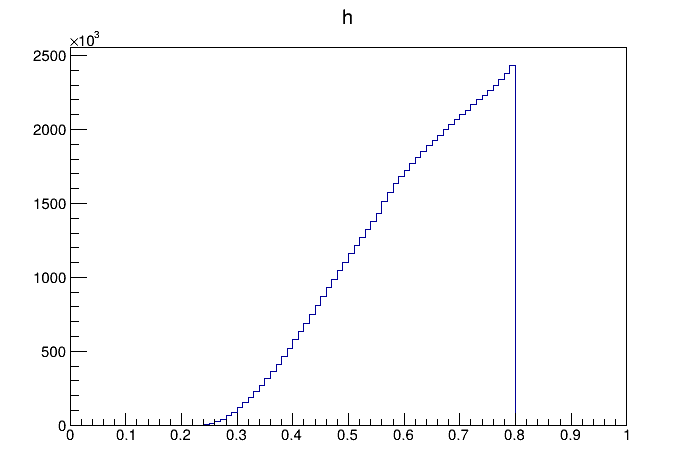

In [68]:
c = ROOT.TCanvas()
h = ROOT.TH1F("h","h",100,0,1)
h.SetStats(0)

chain.Draw("y>>h")
c.Draw()

## Calculating Asymmetries

Note: the inbending and outbending data have a different polarization value...

In [2]:
import ROOT
f = ROOT.TFile("/out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root")
f.ls()

TFile**		/w/hallb-scshelf2102/clas12/users/tjhellst/clas-ana-scaffold-tyler/out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root	
 TFile*		/w/hallb-scshelf2102/clas12/users/tjhellst/clas-ana-scaffold-tyler/out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root	
  KEY: TTree	EventTree;1	EventTree
  KEY: TTree	pippi0;1	Tree


In [3]:
t_pippi0 = f.Get("pippi0")
t_EventTree = f.Get("EventTree")
[print(b.GetName()) for b in  t_pippi0.GetListOfBranches()]
#[print(b.GetName()) for b in  t_EventTree.GetListOfBranches()]

t_EventTree.GetEntry(0)
Pb = t_EventTree.Pol
print(Pb)

#print("EventTree: ",t_EventTree.GetEntries())
#print("pippi0: ",t_pippi0.GetEntries())

hel
run
x
eps
gamma
x_true
Q2
Q2_true
z
pT
xF
xF1
xF2
phi
Mx
Mh
z_true
pT_true
xF_true
xF1_true
xF2_true
phi_true
Mx_true
Mh_true
Mdiphoton
Mdiphoton_true
0.8592000007629395


### MLM Function

In [10]:
from ROOT import RooRealVar, RooArgSet, RooDataSet, RooGenericPdf, RooFit, TMath

def simFit(t, z_min, z_max):
    eps = RooRealVar("eps", "eps", 0, 1)
    phi = RooRealVar("phi", "phi", -2*TMath.Pi(), 2*TMath.Pi())
    hel = RooRealVar("hel", "hel", -1, 1)
    z   = RooRealVar("z",   "z",   z_min, z_max)
    A   = RooRealVar("A",   "asymmetry amplitude", 0, -10, 10)

    ds = RooDataSet("ds", "data", RooArgSet(eps, phi, hel, z),
                    RooFit.Import(t),
                    RooFit.Cut(f"z>={z_min} && z<={z_max}"))

    model = RooGenericPdf("model", "model",
        "1 + 0.8592*sqrt(2*eps*(1-eps))*A*hel*sin(phi)",
        RooArgSet(eps, hel, phi, A))

    model.fitTo(ds)
    return A.getVal(), A.getError()


In [9]:
# don't run this every time, just once is fine. we are now cutting in the roofit code
t = t_pippi0.CopyTree("Mdiphoton<0.16 && 0.115<Mdiphoton && 0.85<Mx && Mx < 1.05")

In [19]:
ROOT.gROOT.cd()
A_results = []
zbin_edges = np.linspace(0.5,1,11)
zbin_centers = []
for iz in range(len(zbin_edges)-1):
    zmin = zbin_edges[iz]
    zmax = zbin_edges[iz+1]
    zbin_centers.append(0.5*(zmin+zmax))
    print("---------------------------------------------------------------------------------")
    print(f"fitting bin {zmin:.3f}<z<{zmax:.3f}: ",iz+1,"of",len(zbin_edges)-1)
    A_results.append(simFit(t,zmin,zmax))

---------------------------------------------------------------------------------
fitting bin 0.500<z<0.550:  1 of 10
---------------------------------------------------------------------------------
fitting bin 0.550<z<0.600:  2 of 10
---------------------------------------------------------------------------------
fitting bin 0.600<z<0.650:  3 of 10
---------------------------------------------------------------------------------
fitting bin 0.650<z<0.700:  4 of 10
---------------------------------------------------------------------------------
fitting bin 0.700<z<0.750:  5 of 10
---------------------------------------------------------------------------------
fitting bin 0.750<z<0.800:  6 of 10
---------------------------------------------------------------------------------
fitting bin 0.800<z<0.850:  7 of 10
---------------------------------------------------------------------------------
fitting bin 0.850<z<0.900:  8 of 10
--------------------------------------------------------

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       90.27679997 Edm =      0.9942137929 NCalls =      5
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 90.27679997
  Edm           : 0.9942137929
  Internal parameters:	[                0]	
  Internal gradient  :	[     -32.73941375]	
  Internal covariance matrix:
[[   0.0037102056]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 500
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =       90.27679997 Edm =      0.9942137929 NCalls =      5
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =       89.25924699 Edm =   0.0001547410067 NCalls =      8
Info in <Minuit2>: VariableMetricBuilder After Hessian
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =       89.25924699 Edm =   0.0001445950025 NCalls =     13
Info in <Minuit2>: Minuit2Minimizer::Hesse Using max-calls 

In [15]:
print(A_results)

[(0.6069764600969373, 0.4154172743461796), (0.19676836292652733, 0.15802135440226167), (0.17387530927544476, 0.09243494519870832), (0.046089293010965704, 0.05646740773511806), (0.1733948749406428, 0.03516114100452075), (0.07909217833680869, 0.024424516215790688), (0.03886869141241247, 0.017248754128939024), (0.04143056614842015, 0.012918909855346931), (0.038616144284470105, 0.010293748530036544), (-0.0020396227774136383, 0.011500335577651118)]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


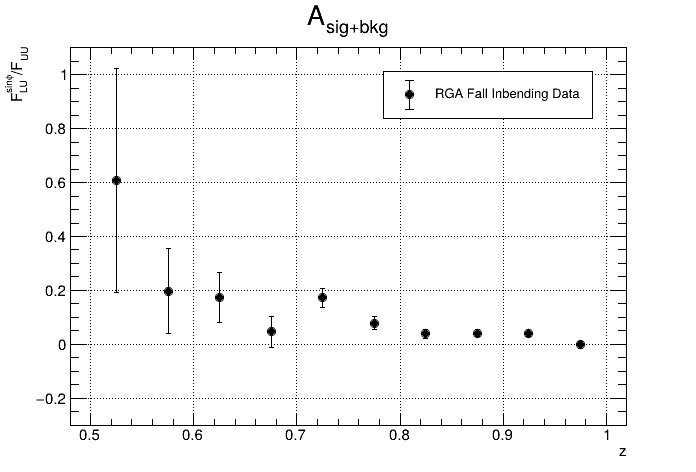

In [31]:
c = ROOT.TCanvas()
c.SetTickx()
c.SetTicky()
c.SetGridx()
c.SetGridy()

A_vals = [entry[0] for entry in A_results]
A_errs = [entry[1] for entry in A_results]

x = np.array(zbin_centers)
y = np.array(A_vals, dtype='float64')
x_errs = np.zeros_like(x)
y_errs = np.array(A_errs,dtype='float64')

print(x_errs)
gr = ROOT.TGraphErrors(len(x),x,y,x_errs,y_errs)

gr.SetMarkerColor(ROOT.kBlack)
gr.SetMarkerStyle(20)
gr.SetTitle("A_{sig+bkg}")
gr.GetXaxis().SetTitle("z")
gr.GetYaxis().SetTitle("F_{LU}^{sin#phi}/F_{UU}")
gr.GetYaxis().SetRangeUser(-0.3,1.1)
leg = ROOT.TLegend(0.55,0.75,0.85,0.85) #xmin,ymin,xmax.ymax
leg.AddEntry(gr,"RGA Fall Inbending Data","ep") #name of object being referred, "title shown", (fit line or point)
leg.SetBorderSize(1)

gr.Draw("AP")
leg.Draw()
c.Draw()

